In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../lending_club')
import config
from data_prep import get_lending_club_data, refine_features

### Import file

In [3]:
%%time
approved = pd.read_parquet('approved.parquet')

CPU times: user 1.52 s, sys: 614 ms, total: 2.13 s
Wall time: 900 ms


In [4]:
from model_prep import divide_by_term

df_60= divide_by_term(approved, 60)
df_36= divide_by_term(approved, 36)
approved = pd.concat([df_60,df_36],axis=0)

In [5]:
approved = approved.loc[approved['issue_d'].dt.year>2007,:]

In [6]:
approved.dtypes

addr_state                         object
annual_inc                        float64
application_type                   object
disbursement_method                object
dti                               float64
earliest_cr_line           datetime64[ns]
emp_length                          int64
emp_title                          object
fico_range_high                   float64
fico_range_low                    float64
grade                              object
home_ownership                     object
initial_list_status                object
inq_last_6mths                    float64
installment                       float64
int_rate                          float64
issue_d                    datetime64[ns]
last_pymnt_d               datetime64[ns]
loan_amnt                         float64
loan_status                         int64
open_acc                          float64
pub_rec                           float64
pub_rec_bankruptcies              float64
purpose                           

# EDA

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
#add year of issue date column
approved['years']= approved['issue_d'].dt.year

## What is the default rate? What are the defaults per loan grade?

In [9]:
approved['loan_status'].value_counts()

1    565404
0     95492
Name: loan_status, dtype: int64

In [10]:
1-(approved['loan_status'].mean())

0.14448869413644505

In [11]:
default = approved['loan_status'].value_counts()
default
my_labels = ['Fully Paid','Charged Off']
my_colors = ['lightgreen','crimson']
my_explode = (0, 0.1)

Text(0.5, 1.0, 'Default Rate')

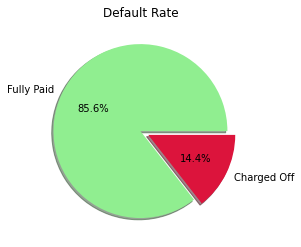

In [12]:
plt.pie(default, labels=my_labels, colors=my_colors, explode=my_explode, shadow = True, autopct='%1.1f%%')
plt.title('Default Rate')
#save

In [110]:
default_rate = approved.groupby('grade').agg({'loan_status':'mean'})
default_rate= (1-default_rate)*100
default_rate=default_rate.reset_index()
default_rate

,grade,loan_status
0,A,5.500993
1,B,11.353537
2,C,18.289454
3,D,23.794905
4,E,29.408411


Text(0.5, 1.0, 'Default Rate per Loan Grade')

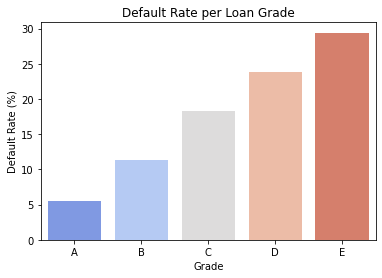

In [111]:
sns.barplot(y='loan_status',x='grade', data=default_rate, palette='coolwarm')
plt.xlabel('Grade')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate per Loan Grade')
#save

In [113]:
default_rate = approved.groupby(['grade','term']).agg({'loan_status':'mean'})
default_rate= (1-default_rate)
default_rate = default_rate.reset_index()
default_rate

,grade,term,loan_status
0,A,36,0.054767
1,A,60,0.083817
2,B,36,0.111894
3,B,60,0.155824
4,C,36,0.179117
5,C,60,0.217252
6,D,36,0.233172
7,D,60,0.272859
8,E,36,0.285661
9,E,60,0.311716


Text(0.5, 1.0, 'Default Rate per Loan Grade')

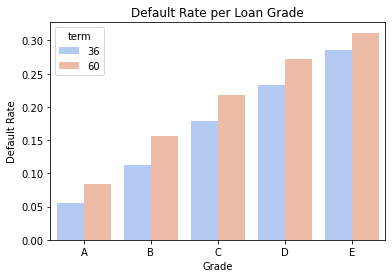

In [114]:
sns.barplot(y='loan_status',x='grade',hue='term', data=default_rate, palette='coolwarm')
plt.xlabel('Grade')
plt.ylabel('Default Rate')
plt.title('Default Rate per Loan Grade')

In [17]:
approved['last_pymnt_d'].fillna(approved['issue_d'], inplace=True)

In [18]:
approved['default_year']=approved['last_pymnt_d'].dt.year

In [19]:
default_rate_year = approved.groupby(['years','term']).mean()['loan_status']
default_rate_year = (1-default_rate_year)*100
default_rate_year = default_rate_year.reset_index()

Text(0.5, 1.0, 'Default Rate Over Time')

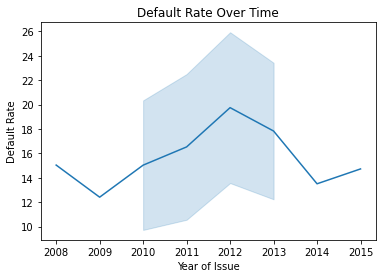

In [20]:
sns.lineplot(y='loan_status',x='years',data=default_rate_year)
plt.xlabel('Year of Issue')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Time')

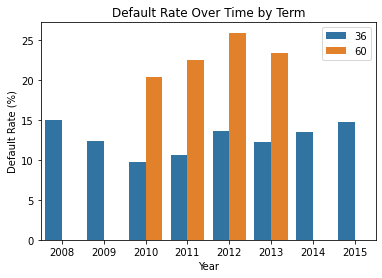

In [21]:
sns.barplot(y='loan_status',x='years',hue='term',data=default_rate_year)
plt.xlabel('Year')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate Over Time by Term')
plt.legend(loc=1)
#save

In [22]:
df_plot = approved.groupby(['years', 'term']).size().reset_index().pivot(columns='term', index='years', values=0)
df_plot

term,36,60
years,,
2008,1097.0,NaN
2009,4626.0,NaN
2010,8382.0,2826.0
2011,14037.0,6759.0
2012,43343.0,8448.0
2013,99799.0,29750.0
2014,160411.0,NaN
2015,281418.0,NaN


Text(0, 0.5, 'Count')

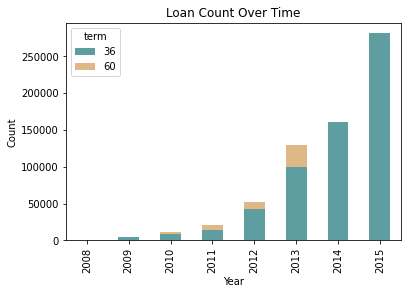

In [171]:
df_plot.plot(kind='bar', stacked=True,color=('cadetblue','burlywood'))
plt.title('Loan Count Over Time')
plt.xlabel('Year')
plt.ylabel('Count')

Text(0.5, 1.0, 'Charged Off vs Fully Paid Over Time')

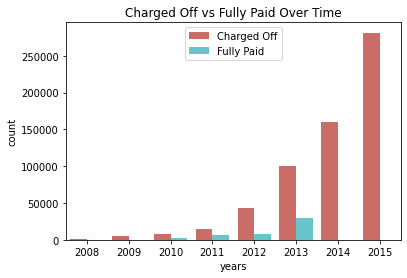

In [24]:
sns.countplot(x='years', hue='term', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('Charged Off vs Fully Paid Over Time')

## Segmentation by FICO scores of the borrowers


Text(0.5, 1.0, 'FICO Score vs Grade')

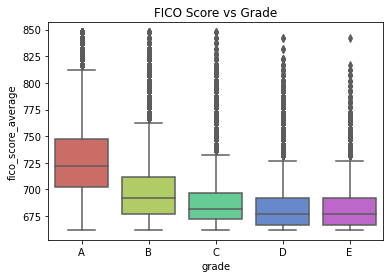

In [25]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='fico_score_average', data=approved, palette='hls',order=my_order)
plt.title('FICO Score vs Grade')

Text(0.5, 1.0, 'Interest Rate vs FICO Score')

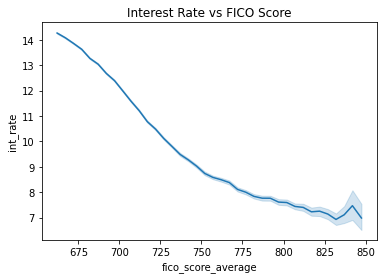

In [26]:
sns.lineplot(y='int_rate',x='fico_score_average', data=approved, palette='hls')
plt.title('Interest Rate vs FICO Score')

Text(0, 0.5, 'FICO Score')

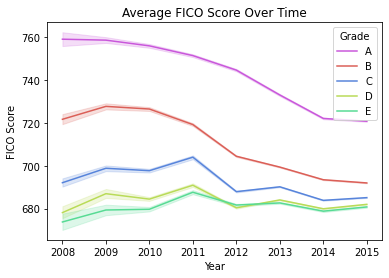

In [27]:
plot = sns.lineplot(y='fico_score_average',x= 'years', hue='grade', data=approved, palette='hls')

handles, labels = plot.get_legend_handles_labels()
handles = [handles[4], handles[0], handles[3], handles[1], handles[2]]
labels = [labels[4], labels[0], labels[3], labels[1], labels[2] ]
plt.legend(handles,labels, title='Grade', loc=1)
plt.title("Average FICO Score Over Time")
plt.xlabel('Year')
plt.ylabel('FICO Score')

In [28]:
default_fico = approved.groupby('fico_score_average').mean()['loan_status']
default_fico = (1-default_fico)*100

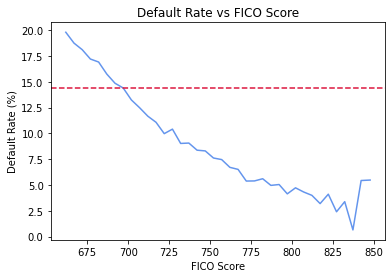

In [119]:
sns.lineplot(y=default_fico.values,x=default_fico.index, color='cornflowerblue')
plt.xlabel('FICO Score')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate vs FICO Score')
plt.axhline(14.4, linestyle='--', color='crimson')

In [30]:
pd.set_option("display.max_columns", 200)
subset = approved.query("fico_score_average>=840 and loan_status==0")
subset

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average,PnL,years,default_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7266455,FL,34000.0,Individual,Cash,10.76,1985-07-01,10,Bell Shoals Baptist Church,850.0,845.0,C,OWN,f,0.0,270.02,15.10,2013-09-01,2014-09-01,11325.0,0,11.0,0.0,0.0,other,12,60,5574.95,Source Verified,335xx,10289,847.5,-5750.05,2013,2014
3625381,TX,48000.0,Individual,Cash,30.56,1992-06-01,10,Health Fitness Corporation,844.0,840.0,A,MORTGAGE,w,0.0,152.18,6.03,2013-03-01,2015-04-01,5000.0,0,13.0,0.0,0.0,credit_card,1,36,3998.07,Verified,752xx,7578,842.0,-1001.93,2013,2015
10130799,NJ,59000.0,Individual,Cash,3.30,1989-10-01,8,Federal Police Sergeant,850.0,845.0,A,MORTGAGE,w,0.0,317.54,8.90,2014-01-01,2014-07-01,10000.0,0,8.0,0.0,0.0,home_improvement,5,36,7374.84,Source Verified,083xx,8858,847.5,-2625.16,2014,2014
12316506,NC,50000.0,Individual,Cash,9.53,1988-10-01,7,Security Installer,844.0,840.0,C,MORTGAGE,w,0.0,850.20,13.65,2014-02-01,2015-12-01,25000.0,0,6.0,0.0,0.0,home_improvement,11,36,19636.05,Verified,284xx,9254,842.0,-5363.95,2014,2015
26200698,IL,216000.0,Individual,Cash,4.43,1997-02-01,4,President,844.0,840.0,D,RENT,w,0.0,1235.52,16.29,2014-09-01,2017-07-01,35000.0,0,8.0,0.0,0.0,house,17,36,42007.68,Source Verified,600xx,6421,842.0,7007.68,2014,2017
48545903,NC,75000.0,Individual,Cash,12.56,1986-07-01,-1,None,850.0,845.0,B,OWN,w,0.0,628.39,8.18,2015-05-01,2015-05-01,20000.0,0,17.0,0.0,0.0,small_business,6,36,0.00,Source Verified,275xx,10531,847.5,-20000.00,2015,2015
65374531,CA,14400.0,Individual,Cash,2.08,1986-04-01,10,cook,844.0,840.0,E,MORTGAGE,w,1.0,176.74,18.20,2015-11-01,2017-10-01,4875.0,0,7.0,0.0,0.0,other,21,36,4884.50,Source Verified,953xx,10806,842.0,9.50,2015,2017
66633602,NY,40000.0,Individual,Cash,0.75,1993-03-01,-1,None,850.0,845.0,C,MORTGAGE,f,0.0,190.02,13.18,2015-12-01,2016-06-01,5625.0,0,6.0,0.0,0.0,moving,13,36,1136.00,Verified,107xx,8310,847.5,-4489.00,2015,2016
67839977,NY,50000.0,Individual,Cash,0.84,1995-09-01,10,IT,844.0,840.0,C,MORTGAGE,w,0.0,736.93,12.59,2015-12-01,2016-07-01,22000.0,0,5.0,0.0,0.0,medical,12,36,6334.28,Not Verified,125xx,7396,842.0,-15665.72,2015,2016


## Interest Rate

Text(0.5, 1.0, 'Interest Rate Over Time')

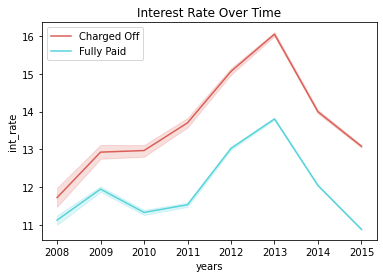

In [31]:
sns.lineplot(y='int_rate',x= 'years', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('Interest Rate Over Time')

Text(0, 0.5, 'Interest Rate (%)')

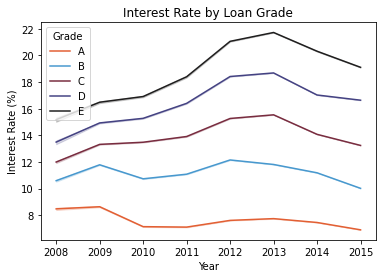

In [88]:
plot = sns.lineplot(y='int_rate',x='years', hue= 'grade', data=approved, palette='icefire')
handles, labels = plot.get_legend_handles_labels()
handles = [handles[4], handles[0], handles[3], handles[1], handles[2]]
labels = [labels[4], labels[0], labels[3], labels[1], labels[2]]
plt.legend(handles,labels, title='Grade', loc=2)
plt.title('Interest Rate by Loan Grade')
plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
#save

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

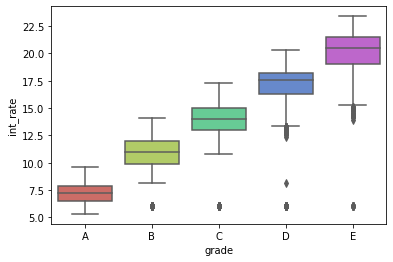

In [74]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='int_rate', data=approved, order=my_order, palette='hls')

## DTI

Text(0.5, 1.0, 'DTI Over Time')

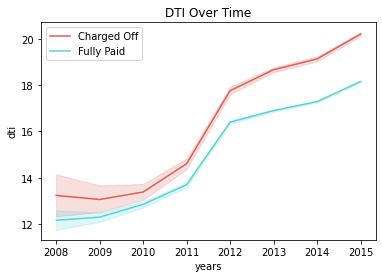

In [33]:
sns.lineplot(y='dti',x= 'years', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('DTI Over Time')

Text(0, 0.5, 'Debt to Income')

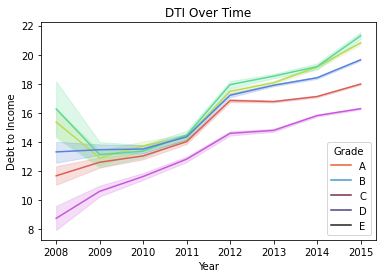

In [90]:
sns.lineplot(y='dti',x='years', hue= 'grade', data=approved, palette='hls')
handles, labels = plot.get_legend_handles_labels()
handles = [handles[4], handles[0], handles[3], handles[1], handles[2]]
labels = [labels[4], labels[0], labels[3], labels[1], labels[2]]
plt.legend(handles,labels, title='Grade', loc=4)
plt.title('DTI Over Time')
plt.xlabel('Year')
plt.ylabel('Debt to Income')

In [35]:
approved['dti'].describe()

count    660896.000000
mean         17.544156
std           8.309068
min           0.000000
25%          11.390000
50%          17.050000
75%          23.250000
max         999.000000
Name: dti, dtype: float64

In [36]:
approved['dti_cut'] = pd.qcut(approved.loc[approved['dti']>0,'dti'], q=10)
approved['dti_cut'].value_counts()

(12.59, 14.83]                  66295
(17.05, 19.35]                  66231
(24.79, 28.8]                   66084
(7.05, 10.13]                   66083
(10.13, 12.59]                  66082
(0.009000000000000001, 7.05]    66059
(21.84, 24.79]                  66051
(28.8, 999.0]                   66009
(19.35, 21.84]                  65844
(14.83, 17.05]                  65810
Name: dti_cut, dtype: int64

In [37]:
default_dti = approved.groupby('dti_cut').mean()['loan_status']
default_dti = (1-default_dti)*100

(-0.5, 9.5)

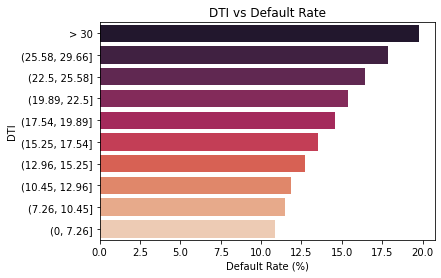

In [38]:
sns.barplot(x=default_dti.values,y=default_dti.index, palette='rocket_r')
plt.ylabel('DTI')
plt.xlabel('Default Rate (%)')
plt.title('DTI vs Default Rate')
plt.yticks([0, 1, 2,3,4,5,6,7,8,9], [
'(0, 7.26]',
'(7.26, 10.45]',
'(10.45, 12.96]',
'(12.96, 15.25]',
'(15.25, 17.54]',
'(17.54, 19.89]',
'(19.89, 22.5]',
'(22.5, 25.58]',
'(25.58, 29.66]',
'> 30'])
plt.ylim(reversed(plt.ylim()))
#save 

In [39]:
approved['inc_cut'] = pd.qcut(approved.annual_inc, q=10)
approved['inc_cut'].value_counts()

(32000.0, 40000.0]       70388
(61000.0, 70000.0]       70299
(1199.999, 32000.0]      68599
(54103.88, 61000.0]      66965
(47840.0, 54103.88]      66016
(80000.0, 96000.0]       66003
(120000.0, 9000000.0]    65228
(96000.0, 120000.0]      64663
(70000.0, 80000.0]       63379
(40000.0, 47840.0]       59356
Name: inc_cut, dtype: int64

In [40]:
default_inc = approved.groupby('inc_cut').mean()['loan_status']
default_inc = (1-default_inc)*100

Text(0.5, 1.0, 'Annual Income vs Default Rate')

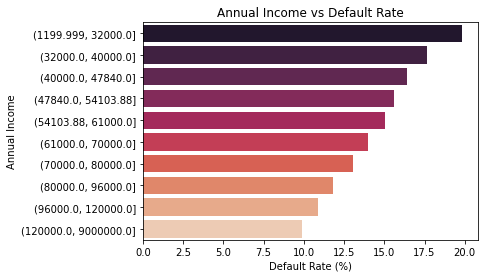

In [41]:
sns.barplot(x=default_inc.values,y=default_inc.index, palette='rocket')
plt.ylabel('Annual Income')
plt.xlabel('Default Rate (%)')
plt.title('Annual Income vs Default Rate')
#save

## Loan Purpose

In [42]:
default_purpose = approved.groupby('purpose').mean()['loan_status']
default_purpose = (1-default_purpose)*100
default_purpose = default_purpose.sort_values(ascending=False).head(10)

Text(0.5, 1.0, 'Loan Purpose vs Default Rate')

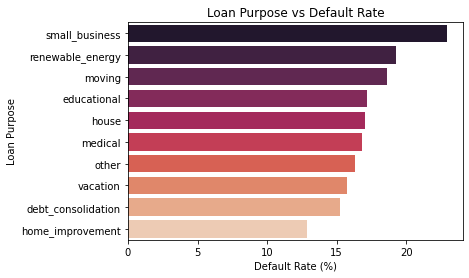

In [43]:
sns.barplot(x=default_purpose.values,y=default_purpose.index, palette='rocket')
plt.ylabel('Loan Purpose')
plt.xlabel('Default Rate (%)')
plt.title('Loan Purpose vs Default Rate')

## Verification Status

In [44]:
approved['verification_status'].value_counts()

Source Verified    228902
Not Verified       216476
Verified           215518
Name: verification_status, dtype: int64

In [45]:
approved['verification_status']= np.where(approved['verification_status']=='Source Verified','Verified',approved['verification_status'])

In [46]:
approved['verification_status'].value_counts()

Verified        444420
Not Verified    216476
Name: verification_status, dtype: int64

In [47]:
default_verif = approved.groupby('verification_status').mean()['loan_status']
default_verif = 1-default_verif

Text(0.5, 1.0, 'Default Rate vs Verification Status')

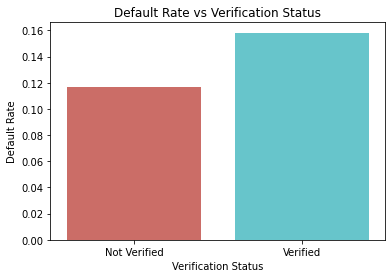

In [48]:
sns.barplot(y=default_verif.values,x=default_verif.index, palette='hls')
plt.xlabel('Verification Status')
plt.ylabel('Default Rate')
plt.title('Default Rate vs Verification Status')

## Employment Length

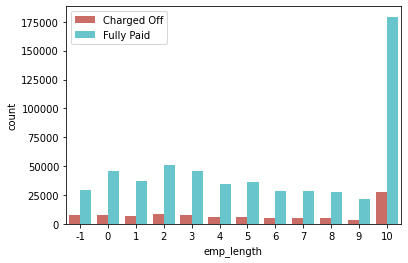

In [121]:
sns.countplot(x='emp_length', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])

In [122]:
approved['emp_na']=np.where(approved['emp_length']==-1,1,0)

In [123]:
default_emp = approved.groupby('emp_na').mean()['loan_status']
default_emp = (1-default_emp)*100

Text(0.5, 1.0, 'Default Rate vs Employment Length')

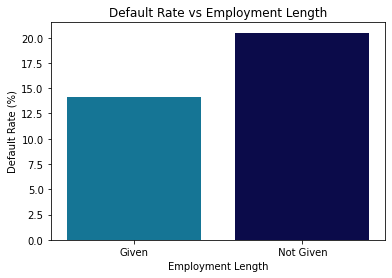

In [177]:
sns.barplot(y=default_emp.values,x=default_emp.index, palette="ocean_r")
plt.xlabel('Employment Length')
plt.ylabel('Default Rate (%)')
plt.xticks([0, 1], ['Given',' Not Given'])
plt.title('Default Rate vs Employment Length')

In [53]:
default_emp = approved.groupby('emp_length').mean()['loan_status']
default_emp = (1-default_emp)*100

Text(0.5, 1.0, 'Default Rate vs Employment Length')

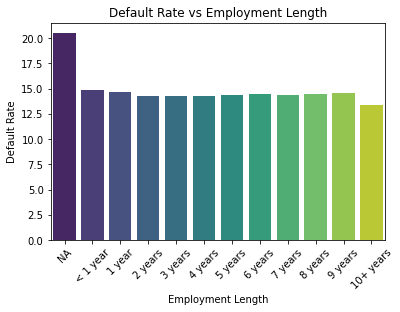

In [54]:
sns.barplot(y=default_emp.values,x=default_emp.index, palette="viridis")
plt.xlabel('Employment Length')
plt.ylabel('Default Rate')
plt.xticks([0, 1, 2,3,4,5,6,7,8,9,10,11], ['NA','< 1 year', '1 year', 
            '2 years', '3 years', '4 years', '5 years', '6 years', 
            '7 years', '8 years', '9 years', '10+ years'])
plt.xticks(rotation=45)
plt.title('Default Rate vs Employment Length')

## Home Ownership

In [55]:
approved['home_ownership'].value_counts()

MORTGAGE    315550
RENT        279592
OWN          65576
OTHER          139
NONE            37
ANY              2
Name: home_ownership, dtype: int64

In [56]:
home = approved.copy()

In [57]:
home['home_ownership'].replace('MORTGAGE', 'OWN', inplace = True)
home['home_ownership'].replace('OWN', 'Home Ownership', inplace = True)
home['home_ownership'].replace('RENT', 'Rent', inplace = True)
home = home[~home['home_ownership'].isin(['OTHER', 'NONE', 'ANY'])]

In [58]:
default_home = home.groupby('home_ownership').mean()['loan_status']
default_home = (1-default_home) * 100

[Text(0.5, 1.0, 'Default Rate vs Home Ownership'),
 Text(0.5, 0, 'Home Ownership Status'),
 Text(0, 0.5, 'Default Rate (%)')]

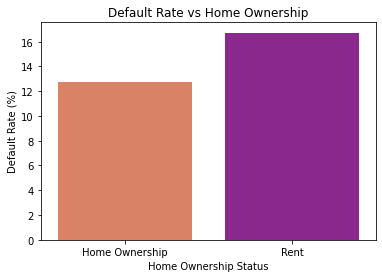

In [154]:
fig = sns.barplot(x=default_home.index, y=default_home.values, data=approved, palette='plasma_r')
fig.set(title = 'Default Rate vs Home Ownership', xlabel = 'Home Ownership Status', ylabel = 'Default Rate (%)')
#remove any and order
#mortgage, own = home ownership and rent - 2 bars

## Default rate vs # of credit inquiries

In [60]:
approved['inq']=np.where(approved['inq_last_6mths']>=4,4,approved['inq_last_6mths'])

In [61]:
default_inqs = approved.groupby('inq').mean()['loan_status']
default_inqs = (1-default_inqs) * 100

In [62]:
approved['inq'].value_counts()

0.0    369741
1.0    180879
2.0     71248
3.0     28347
4.0     10681
Name: inq, dtype: int64

([<matplotlib.axis.XTick at 0x7ff6a66b48e0>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0+')])

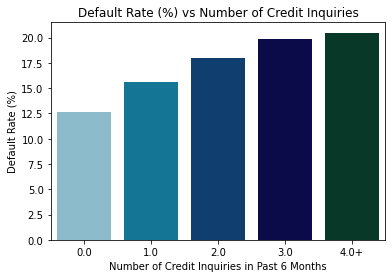

In [176]:
sns.barplot(y=default_inqs.values,x=default_inqs.index, palette="ocean_r")
plt.xlabel('Number of Credit Inquiries in Past 6 Months')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate (%) vs Number of Credit Inquiries')
plt.xticks([0,1,2,3,4], ['0.0', '1.0', '2.0', '3.0', '4.0+'])
#save

In [64]:
approved.query("inq_last_6mths==8")

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average,PnL,years,default_year,dti_cut,inc_cut,emp_na,inq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
533380,MA,33000.0,Individual,Cash,14.94,1997-10-01,10,cvs pharmacy,744.0,740.0,D,MORTGAGE,f,8.0,122.45,16.32,2010-06-01,2011-12-01,5000.0,1,20.0,0.0,0.0,home_improvement,20,60,6048.103124,Verified,020xx,4626,742.0,1048.103124,2010,2011,"(14.83, 17.05]","(32000.0, 40000.0]",0,4.0
657025,CO,27600.0,Individual,Cash,16.83,1976-12-01,7,Alamosa Public Schools,769.0,765.0,D,MORTGAGE,f,8.0,333.03,15.65,2011-01-01,2016-02-01,13800.0,1,11.0,0.0,0.0,car,19,60,19981.643198,Verified,811xx,12449,767.0,6181.643198,2011,2016,"(14.83, 17.05]","(1199.999, 32000.0]",0,4.0
666496,IL,35000.0,Individual,Cash,24.75,1996-12-01,7,Roys Body Shop,744.0,740.0,D,OWN,f,8.0,124.48,15.28,2011-02-01,2014-03-01,5200.0,1,7.0,0.0,0.0,car,18,60,7073.703155,Not Verified,629xx,5175,742.0,1873.703155,2011,2014,"(21.84, 24.79]","(32000.0, 40000.0]",0,4.0
696388,MI,82000.0,Individual,Cash,14.59,1994-01-01,10,Northville Public Schools,799.0,795.0,D,MORTGAGE,f,8.0,335.13,15.28,2011-03-01,2016-03-01,14000.0,1,10.0,0.0,0.0,home_improvement,18,60,20105.810027,Verified,481xx,6268,797.0,6105.810027,2011,2016,"(12.59, 14.83]","(80000.0, 96000.0]",0,4.0
766671,FL,146000.0,Individual,Cash,9.96,1996-07-01,10,Marriott International,749.0,745.0,E,MORTGAGE,f,8.0,639.54,17.88,2011-06-01,2012-03-01,35000.0,1,9.0,0.0,0.0,debt_consolidation,25,60,28489.760904,Verified,331xx,5448,747.0,-6510.239096,2011,2012,"(7.05, 10.13]","(120000.0, 9000000.0]",0,4.0
884507,MI,30000.0,Individual,Cash,22.96,1978-09-01,8,golden brown bakery,759.0,755.0,D,OWN,f,8.0,49.46,16.77,2011-09-01,2016-10-01,2000.0,1,6.0,0.0,0.0,other,17,60,2967.427698,Not Verified,490xx,12053,757.0,967.427698,2011,2016,"(21.84, 24.79]","(1199.999, 32000.0]",0,4.0
1368779,KY,218000.0,Individual,Cash,1.07,1985-10-01,10,Presbyterian Publishing Corp.,749.0,745.0,E,MORTGAGE,f,8.0,683.25,21.49,2012-07-01,2012-12-01,25000.0,1,5.0,0.0,0.0,debt_consolidation,23,60,27195.602034,Verified,402xx,9770,747.0,2195.602034,2012,2012,"(0.009000000000000001, 7.05]","(120000.0, 9000000.0]",0,4.0
1587833,MI,82000.0,Individual,Cash,18.59,2000-06-01,10,kroger,754.0,750.0,D,MORTGAGE,w,8.0,649.21,19.05,2012-10-01,2017-03-01,25000.0,1,11.0,0.0,0.0,debt_consolidation,19,60,38656.019830,Verified,481xx,4505,752.0,13656.019830,2012,2017,"(17.05, 19.35]","(80000.0, 96000.0]",0,4.0
353370,CO,42000.0,Individual,Cash,23.63,1994-04-01,2,Jefferson count schools,744.0,740.0,C,RENT,f,8.0,165.86,11.91,2008-08-01,2010-01-01,5000.0,1,19.0,0.0,0.0,credit_card,13,36,5678.670000,Not Verified,805xx,5236,742.0,678.670000,2008,2010,"(21.84, 24.79]","(40000.0, 47840.0]",0,4.0


## PnL
### How much of principal is typically paid off before default? Broken out by loan grade?

In [65]:
approved.groupby('grade')['PnL'].mean()

grade
A    1001.756625
B    1167.457566
C    1278.154733
D    1271.603028
E    1867.478122
Name: PnL, dtype: float64

[Text(0.5, 1.0, 'Profit/Loss by Grade'),
 Text(0.5, 0, 'Grade'),
 Text(0, 0.5, 'Average Profit $')]

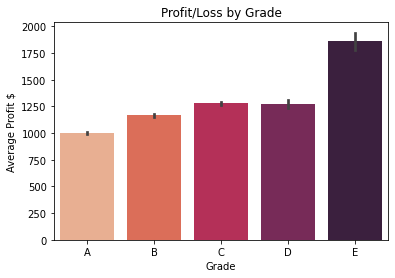

In [66]:
my_order = ['A','B','C','D','E']
fig = sns.barplot(y='PnL',x='grade',data=approved,order=my_order, palette='rocket_r')
fig.set(title = 'Profit/Loss by Grade', xlabel = 'Grade', ylabel = 'Average Profit $')

## Loan Duration
### True life of loans [last_pmnt_d - issue_d] vs term (36/60)

In [67]:
approved['tru_life']=approved['last_pymnt_d']-approved['issue_d']
approved['tru_months'] = approved['tru_life'].dt.days / 30.4167

In [68]:
approved['tru_months'].describe()

count    660896.000000
mean         25.316971
std          12.093485
min           0.000000
25%          15.057518
50%          27.024628
75%          36.032837
max          70.027321
Name: tru_months, dtype: float64

In [69]:
approved['true']=approved['tru_months']/approved['term']

(0.0, 1.0)

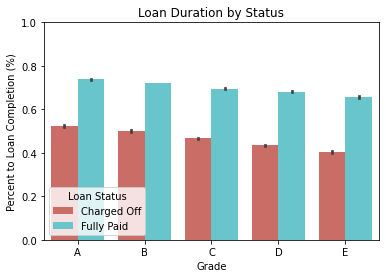

In [71]:
my_order = ['A','B','C','D','E']
plot = sns.barplot(x='grade', y='true',hue='loan_status', data=approved, palette='hls', order=my_order)
plt.title('Loan Duration')
my_labels=['Charged Off', 'Fully Paid']
handles, labels = plot.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = my_labels
plt.legend(handles,labels, title='Loan Status', loc=3)
plt.ylabel('Percent to Loan Completion (%)')
plt.xlabel('Grade')
plt.title('Loan Duration by Status')
plt.ylim(0,1)

#prepayment risk vs default risk

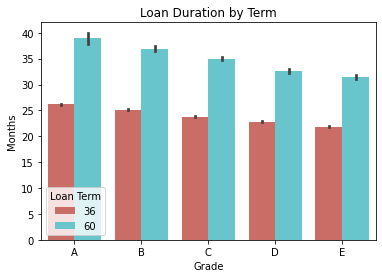

In [71]:
my_order = ['A','B','C','D','E']
fig = sns.barplot(x='grade', y='tru_months', hue='term', data=approved, palette='hls', order=my_order)
fig.set(title = 'Loan Duration by Term', xlabel = 'Grade', ylabel = 'Months')
fig.legend(title = 'Loan Term', loc = 'lower left')
#save

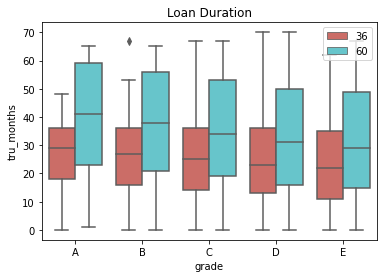

In [72]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='tru_months', hue='term', data=approved, palette='hls', order=my_order)
plt.title('Loan Duration')
plt.legend(loc=1)

In [73]:
approved.groupby(['term','grade'])[['tru_months']].median()

tru_months
term grade            
36   A       29.030105
     B       27.057505
     C       25.052027
     D       23.046550
     E       22.027373
60   A       41.062969
     B       37.972561
     C       34.027360
     D       31.002706
     E       29.030105

In [74]:
approved.groupby('term')[['tru_months']].median()

,tru_months
term,
36,26.958875
60,33.041060


<AxesSubplot:xlabel='term', ylabel='tru_months'>

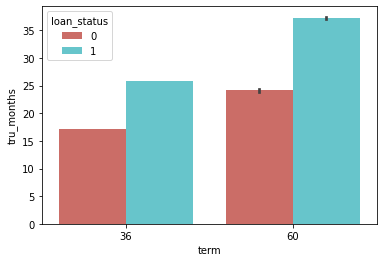

In [75]:
sns.barplot(x='term', y='tru_months', hue='loan_status', data=approved, palette='hls')

## Location: by Zip Code and State

In [76]:
approved['zip_code'].value_counts().head(10)

945xx    7641
112xx    7416
750xx    7032
606xx    6896
100xx    6154
300xx    6035
900xx    6029
331xx    5797
070xx    5655
770xx    5443
Name: zip_code, dtype: int64

In [77]:
default_zip = approved.groupby('zip_code').agg({'loan_status':['mean','count']})
default_zip.sort_values(by=('loan_status','count'),ascending=False).head(20)
default_zip.columns=['default_rate','count']
default_zip.default_rate = 1 - default_zip.default_rate
subset = default_zip.query("count>20 and default_rate<=.2")
subset.sort_values(by='default_rate',ascending=False)


,default_rate,count
zip_code,,
362xx,0.200000,280
994xx,0.200000,30
723xx,0.199203,251
386xx,0.199187,492
178xx,0.196552,290
...,...,...
822xx,0.060000,50
865xx,0.053571,56
823xx,0.050000,40


In [90]:
default_state = approved.groupby('addr_state').mean()[['loan_status']]
default_state = 1-default_state
default_state.sort_values(by='loan_status',ascending=False)

,loan_status
addr_state,
IA,0.333333
NE,0.191744
MS,0.183218
NV,0.177083
AR,0.175842
OK,0.171555
AL,0.168669
TN,0.163995
LA,0.161705


In [92]:
approved['addr_state'].value_counts()

CA    101676
NY     56295
TX     53216
FL     46367
IL     26694
NJ     24669
PA     22473
GA     21389
OH     21131
VA     18931
NC     17695
MI     17015
AZ     15427
MA     15278
MD     15119
WA     14610
CO     13853
MN     11689
MO     10378
CT     10110
NV      9696
IN      9482
TN      8921
WI      8577
OR      8391
AL      7909
LA      7693
SC      7592
KY      6039
OK      5864
KS      5784
AR      4868
UT      4557
NM      3697
HI      3402
NH      3160
WV      3033
RI      2882
MS      2467
DC      1934
MT      1921
DE      1770
AK      1682
WY      1493
SD      1366
VT      1300
NE       751
ME       334
ND       306
ID         7
IA         3
Name: addr_state, dtype: int64

## Disbursement Method

In [80]:
approved['disbursement_method'].value_counts()

Cash    660896
Name: disbursement_method, dtype: int64

In [81]:
default_state = approved.groupby('disbursement_method').mean()['loan_status']
default_state = 1-default_state
default_state.sort_values(ascending=False)

disbursement_method
Cash    0.144489
Name: loan_status, dtype: float64

## Days Since First Credit

In [79]:
approved['days_since_first_credit'] = approved['issue_d'] - approved['earliest_cr_line']

In [80]:
approved['days_since_first_credit'] = approved['days_since_first_credit'].dt.days

In [81]:
approved['days_cut'] = pd.qcut(approved.days_since_first_credit, q=10)
approved['days_cut'].value_counts()

(1094.999, 2861.0]    66771
(4291.0, 4809.0]      66722
(6788.0, 7852.0]      66121
(2861.0, 3713.0]      66118
(9677.0, 25933.0]     66081
(5355.0, 5967.0]      66081
(7852.0, 9677.0]      66008
(5967.0, 6788.0]      65965
(4809.0, 5355.0]      65543
(3713.0, 4291.0]      65486
Name: days_cut, dtype: int64

In [82]:
default_day = approved.groupby('days_cut').mean()['loan_status']
default_day = (1-default_day) * 100

[Text(0.5, 1.0, 'Credit History vs Default Rate'),
 Text(0.5, 0, 'Default Rate (%)'),
 Text(0, 0.5, 'Credit History in Days')]

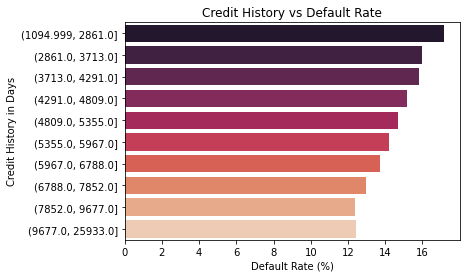

In [83]:
fig = sns.barplot(x=default_day.values,y=default_day.index, palette='rocket')
fig.set(title='Credit History vs Default Rate', xlabel='Default Rate (%)',ylabel='Credit History in Days')
#save